In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
#!pip install palmerpenguins
from palmerpenguins import load_penguins

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier, plot_tree



This notebook is designed to illustrate a typical machine learning (ML) workflow. The focus is on *how they work*, so please don't get discouraged if the python code looks a little intimidating! I'm happy to explain exactly how the code work afterwards, but you can also copy-paste the code into chatGPT and ask it to explain it to you as if you were 5 years old (at least that's my guess of my brain).

### colors to use for plotting, 2 for 2 species

In [50]:
# colors selected from https://coolors.co/palettes/trending
pal = ["#219ebc", "#fb8500"] 

### select species to analyze

In [51]:
species_to_analyze = ['Adelie',  'Gentoo']
assert len(species_to_analyze) > 1, "You need to select more than one species to analyze!"

### load dataset, clean DataFrame

In [52]:
penguins = load_penguins()

# ADD COLUMN that assigns each species a color, useful to make colors consistent across plots
penguins["color"] = penguins["species"].map({"Adelie": pal[0], "Gentoo": pal[1]})

# EXCLUDE ROWS with missing data 
penguins = penguins.dropna(subset = ["bill_length_mm", "bill_depth_mm", "species", "flipper_length_mm", "body_mass_g"])

# SELECT ROWS containing the species of interest, specified above
penguins = penguins.loc[penguins['species'].isin(species_to_analyze)]

# RESET INDEX, since some rows may have been eliminated from selecting species
penguins.reset_index(drop=True, inplace=True)

# INSPECT DataFrame
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year,color
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007,#219ebc
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007,#219ebc
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007,#219ebc
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007,#219ebc
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007,#219ebc
...,...,...,...,...,...,...,...,...,...
269,Gentoo,Biscoe,47.2,13.7,214.0,4925.0,female,2009,#fb8500
270,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,female,2009,#fb8500
271,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,male,2009,#fb8500
272,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,female,2009,#fb8500


In [53]:
print("SPECIES:", penguins['species'].unique())
print("YEARS:", penguins['year'].unique())
print("ISLAND:", penguins['island'].unique())

SPECIES: ['Adelie' 'Gentoo']
YEARS: [2007 2008 2009]
ISLAND: ['Torgersen' 'Biscoe' 'Dream']


### Dataset description

See [here](https://allisonhorst.github.io/palmerpenguins/) for a description/image of bill length/depth. 


Machine learning (ML) involves building a model to predict a response using other features that we've measured. These features must have some *informative* relationship with the response, i.e. as a feature changes values, so does the response. Let's double check that this is the case with our data!

NOTE: in practice, we may have measured *many* features, only some are informative, and we aren't sure which ones. Some ML algorithms can perform *feature selection* in which they essentially find and focus on the informative features. Today, we have preselected informative features.


### Plot features to assess relationship with response (species)

/var/folders/m1/0x4jd4t51ws3hts4kt4yy68c0000gn/T/ipykernel_64444/2686240273.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.catplot(data=penguins_forplot,


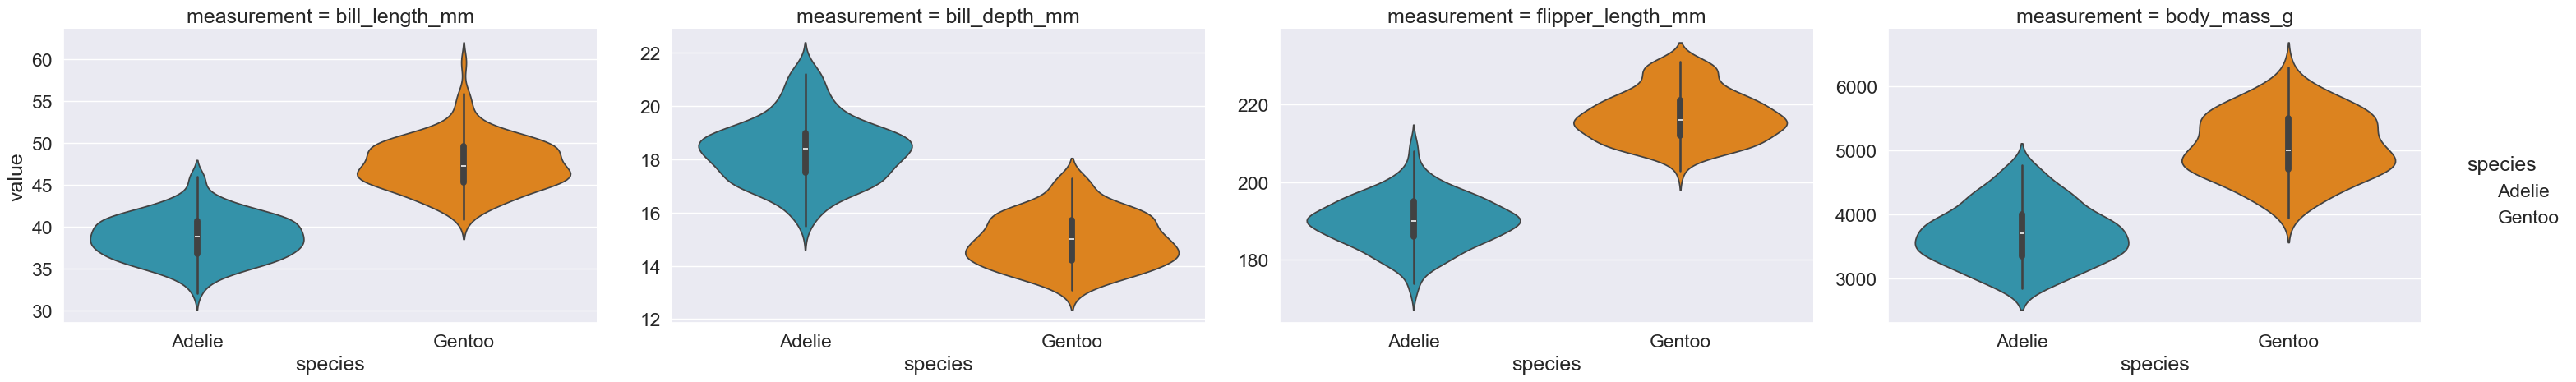

In [54]:
# create a new DataFrame with only the columns of interest for plotting, converting the DataFrame from wide to long format
penguins_forplot = penguins[['species', 
                            "bill_length_mm", 
                            "bill_depth_mm", 
                            "flipper_length_mm", 
                            "body_mass_g"]]

penguins_forplot = penguins_forplot.melt(id_vars=['species'], 
                                       var_name='measurement', 
                                       value_name='value')

# make plot!
sns.set(font_scale=1.5) # change font size using seaborn
sns.catplot(data=penguins_forplot, 
            col="measurement", 
            y="value", 
            x="species", 
            kind='violin', 
            palette=pal, height=5, aspect=1.5, sharey=False)


In [55]:
# body mass can vary depending on sex; are sex ratios of these samples very different between species?
penguins[['species', 'sex']].groupby('species').value_counts()

species  sex   
Adelie   female    73
         male      73
Gentoo   male      61
         female    58
Name: count, dtype: int64

 ### Using multiple features -- simultaneously -- to make a decision can be very powerful


Each of the features above seem to be informative of the response, but there's *some* overlap. However, ML algorithms are designed to use information from all features simultaneously to make a decision. Let's see how this can lead to more accurate models.

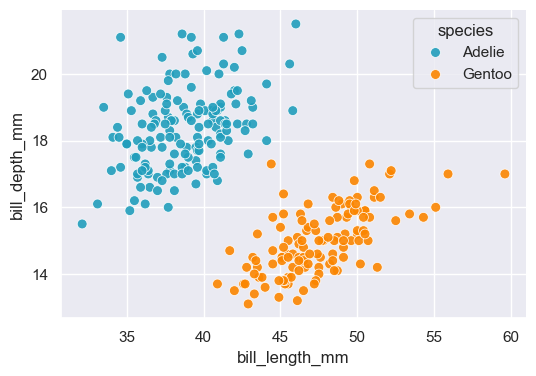

In [56]:
plt.figure(figsize=(6, 4))
hue_order = ["Adelie", "Gentoo"]
sns.set(font_scale=1)
sns.scatterplot(data=penguins, 
                x="bill_length_mm", 
                y="bill_depth_mm", 
                hue="species", 
                hue_order = hue_order, palette = pal, alpha=0.9, s=50)
sns.despine()

The distribution of bill depth and length is somewhat overlapping between some species, but when combined together there's clear separation between species. ML algorithms will see this, and make a 'decision boundary' right between the cleanly separated species. If data are on one side of the decision boundary, they get classified as species 1, if they're on the other side, species 2.

Let's also take a quick peek at the other two features.

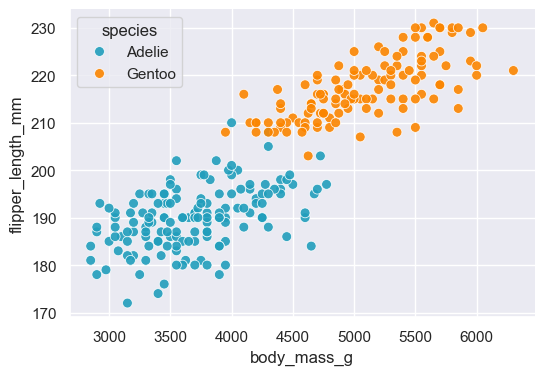

In [57]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=penguins, 
                x="body_mass_g", 
                y="flipper_length_mm", 
                hue="species", 
                hue_order = hue_order, palette = pal, alpha=0.9, s=50)
sns.despine()

Either set of two features are informative for predicting species, but let's proceed with the bill features.

Moreover, let's store our data in more informatively-named tables: `features` as `X`, and `response` as `Y`

In [58]:
X = penguins[["bill_length_mm", "bill_depth_mm"]]
Y = penguins["species"]

# Feature normalization

Rescaling our features so that they all have similar values and ranges is best practice! Here we will use a function from scikit learn that performs 'z-score normalization': for each feature, we will take it's value, subtract the mean, and divide by the standard deviation.

<Axes: ylabel='Count'>

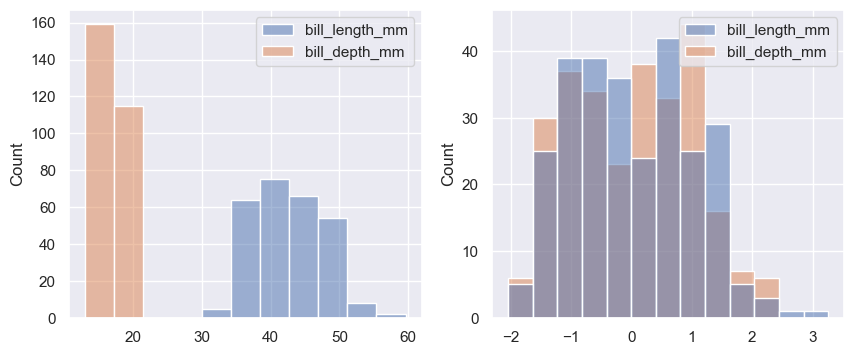

In [59]:
# Initiate the scaler
scaler = StandardScaler().set_output(transform="pandas")

# Fit/transform to all numeric data
X_normalized = scaler.fit_transform(X)

# instead of blindly trusting this worked, let's verify!
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.histplot(X, ax = axs[0])
sns.histplot(X_normalized, ax = axs[1])

### Split data into 2 parts, one for training the model, one for testing how well it performs

In [60]:
# we also set the random_state to ensure we all get the same results!
X_train, X_test, Y_train, Y_test = train_test_split(X_normalized, Y, test_size=0.3, random_state=11)
print("X_train dimensions ", X_train.shape)
print("X_test dimensions ", X_test.shape)

X_train dimensions  (191, 2)
X_test dimensions  (83, 2)


In [61]:
X_train

,bill_length_mm,bill_depth_mm
128,0.269391,0.579116
0,-0.694729,0.927421
112,-0.096975,1.325484
122,-0.251234,0.827906
157,0.520062,-1.112651
...,...,...
161,-0.347646,-1.560472
269,0.867145,-1.560472
91,-1.678132,0.131295
80,0.038002,0.380085


### Let's start with the *simplest* ML algorithm for classification: Logistic regression

In [62]:
log_reg = LogisticRegression().fit(X_train, Y_train)
log_reg.score(X_test, Y_test)

1.0

Wow! That's an accurate model! How can it be so accurate? Let's see how it made it's decision boundary.

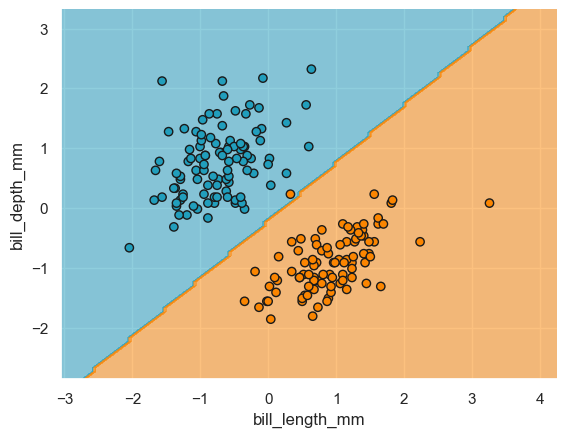

In [63]:
cmap = ListedColormap(sorted(penguins['color'].unique())) # convert our color palette to a matplotlib colormap object
disp = DecisionBoundaryDisplay.from_estimator(
    log_reg, X_train, response_method="predict",
    xlabel=X_train.columns[0], ylabel=X_train.columns[1],
    alpha=0.5, cmap=cmap
    )
disp.ax_.scatter(X_train[X_train.columns[0]], X_train[X_train.columns[1]], c=penguins['color'].loc[Y_train.index], edgecolor="k")
sns.despine()

Text(0.5, 1.0, 'Test Data')

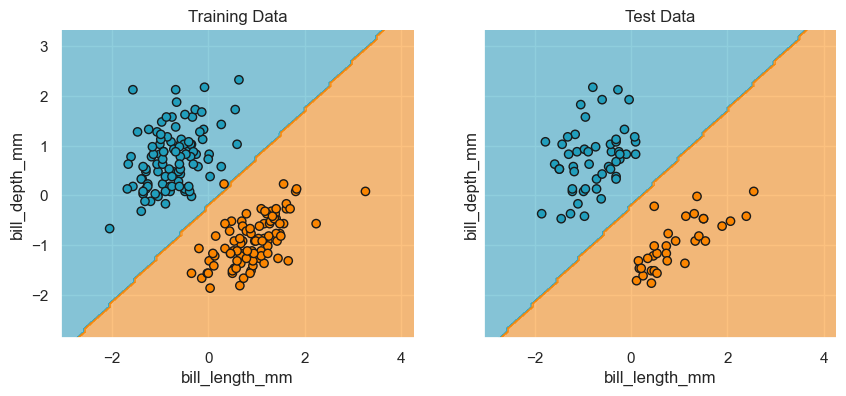

In [64]:

cmap = ListedColormap(sorted(penguins['color'].unique())) # convert our color palette to a matplotlib colormap object

def get_decision_boundary(X, classifier, fig_panel):
    # this function returns a decision boundary display object, and we can specify the figure panel to plot it on
    return DecisionBoundaryDisplay.from_estimator(
        classifier, X, response_method="predict",
        xlabel=X.columns[0], ylabel=X.columns[1],
        alpha=0.5, cmap=cmap, ax=axs[fig_panel])

def plot_decision_boundary_with_data(disp, X, Y):
    # this function takes a decision boundary display object, and plots it along with the data
    disp.ax_.scatter(X[X.columns[0]], X[X.columns[1]], c=penguins['color'].loc[Y.index], edgecolor="k")
    sns.despine()

# specify the laytout of the figure
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# get the decision boundary objects to display
disp_train = get_decision_boundary(X_train, log_reg, fig_panel=0)
disp_test = get_decision_boundary(X_train, log_reg, fig_panel=1)

# plot decision boundary along with training and test data
plot_decision_boundary_with_data(disp_train, X_train, Y_train)
plot_decision_boundary_with_data(disp_test, X_test, Y_test)

# make titles
axs[0].set_title("Training Data")
axs[1].set_title("Test Data")


# Decision Tree classifier

Our accuracy is already incredibly good with the simplest ML algorithm, so in practice we'd likely stop there. However, in practice our features may be less informative and not allow for a clean separation of the species in 'feature space', and more complex models will have better prediction accuracy. So, to illustrate another extremely popular ML model that's more complex than logistic regression, let's make a decision tree to classify these penguin species.

Decision trees use a series of "if-then" rules to create a decision boundary, splitting feature space into regions that separete the species we're trying to classify. These 'if-then' rules can create more complicated decision boundaries than simple straight lines.

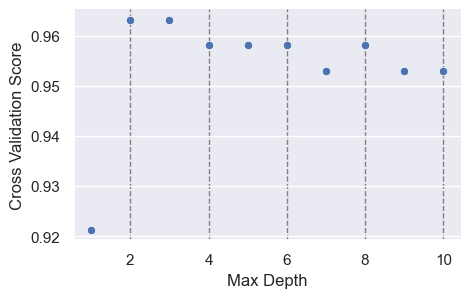

In [65]:
#Cross validate on depths ranging from 1 to 30
N = 10

#Create np.array() to store cross validation scores
# scores = np.zeros(N)
scores = []

#Loop through depths from 1-30
for d in range(1, N + 1):
    #Decision Tree model with max_depth = d
    T = DecisionTreeClassifier(max_depth = d)
    #Store the average of 5 cross validation scores in scores
    scores.append(cross_val_score(T, X_train, Y_train, cv = 5).mean())
    
plt.figure(figsize=(5, 3))
sns.scatterplot(x = range(1, N + 1), y = scores)
plt.grid(axis='x', color='gray', linestyle='--', linewidth=1)
plt.xlabel("Max Depth")
plt.ylabel("Cross Validation Score")
sns.despine()




In [66]:
#Decision Tree model with max_depth = best_depth chosen from cross validation
T = DecisionTreeClassifier(max_depth = 2, random_state = 11)
T.fit(X_train, Y_train)
print(T.score(X_train, Y_train))
print(T.score(X_test, Y_test))

0.9947643979057592
1.0


Text(0.5, 1.0, 'Test Data')

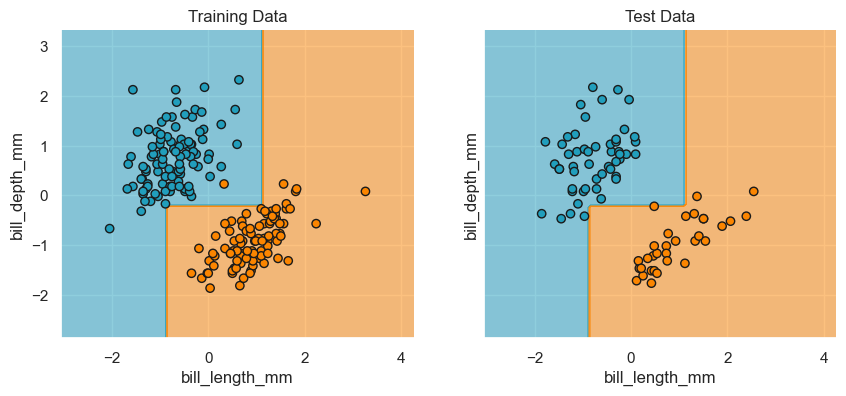

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# use the same function above, which we've made flexible enough to work with any classifier
# this avoids making redundant code, which leads to very long notebooks that are hard to read!
disp_train = get_decision_boundary(X_train, T, fig_panel=0)
disp_test = get_decision_boundary(X_train, T, fig_panel=1)

# plot decision boundary along with training and test data
plot_decision_boundary_with_data(disp_train, X_train, Y_train)
plot_decision_boundary_with_data(disp_test, X_test, Y_test)

# make titles
axs[0].set_title("Training Data")
axs[1].set_title("Test Data")


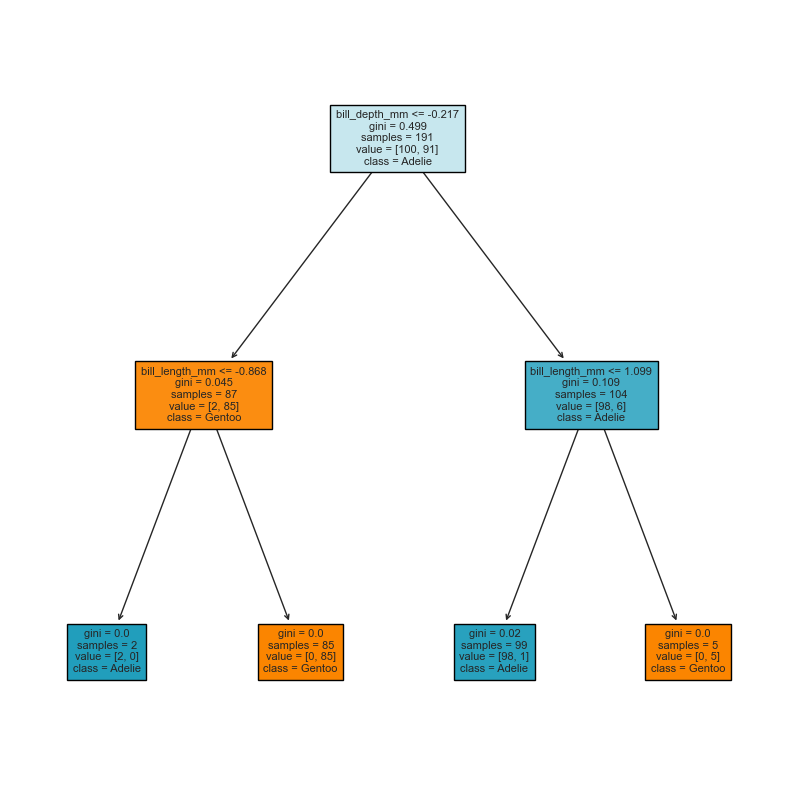

In [68]:
plt.figure(figsize=(10, 10))

artists = plot_tree(T, feature_names=X_train.columns, class_names=penguins['species'].unique(), filled=True, fontsize=8)

for artist, impurity, value in zip(artists, T.tree_.impurity, T.tree_.value):
    # let the max value decide the color; whiten the color depending on impurity (gini)
    r, g, b = to_rgb(pal[np.argmax(value)])
    f = impurity * (3/2) # for N colors: f = impurity * N/(N-1) if N>1 else 0
    artist.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
    artist.get_bbox_patch().set_edgecolor('black')

### Exercise: change the `max_depth` hyperparameter to 2, forcing the decision tree to only get to make 1 rule. What happens?

In [69]:
T.predict([[-1, 0]])

/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['Adelie'], dtype=object)

/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=vector, **plot_kwargs)
/Users/bjarnold/miniforge3/envs/datascience/lib/python3.12/site-packages/seaborn/axisgrid.py:1513: FutureWarning: 

`shade` is now deprecat

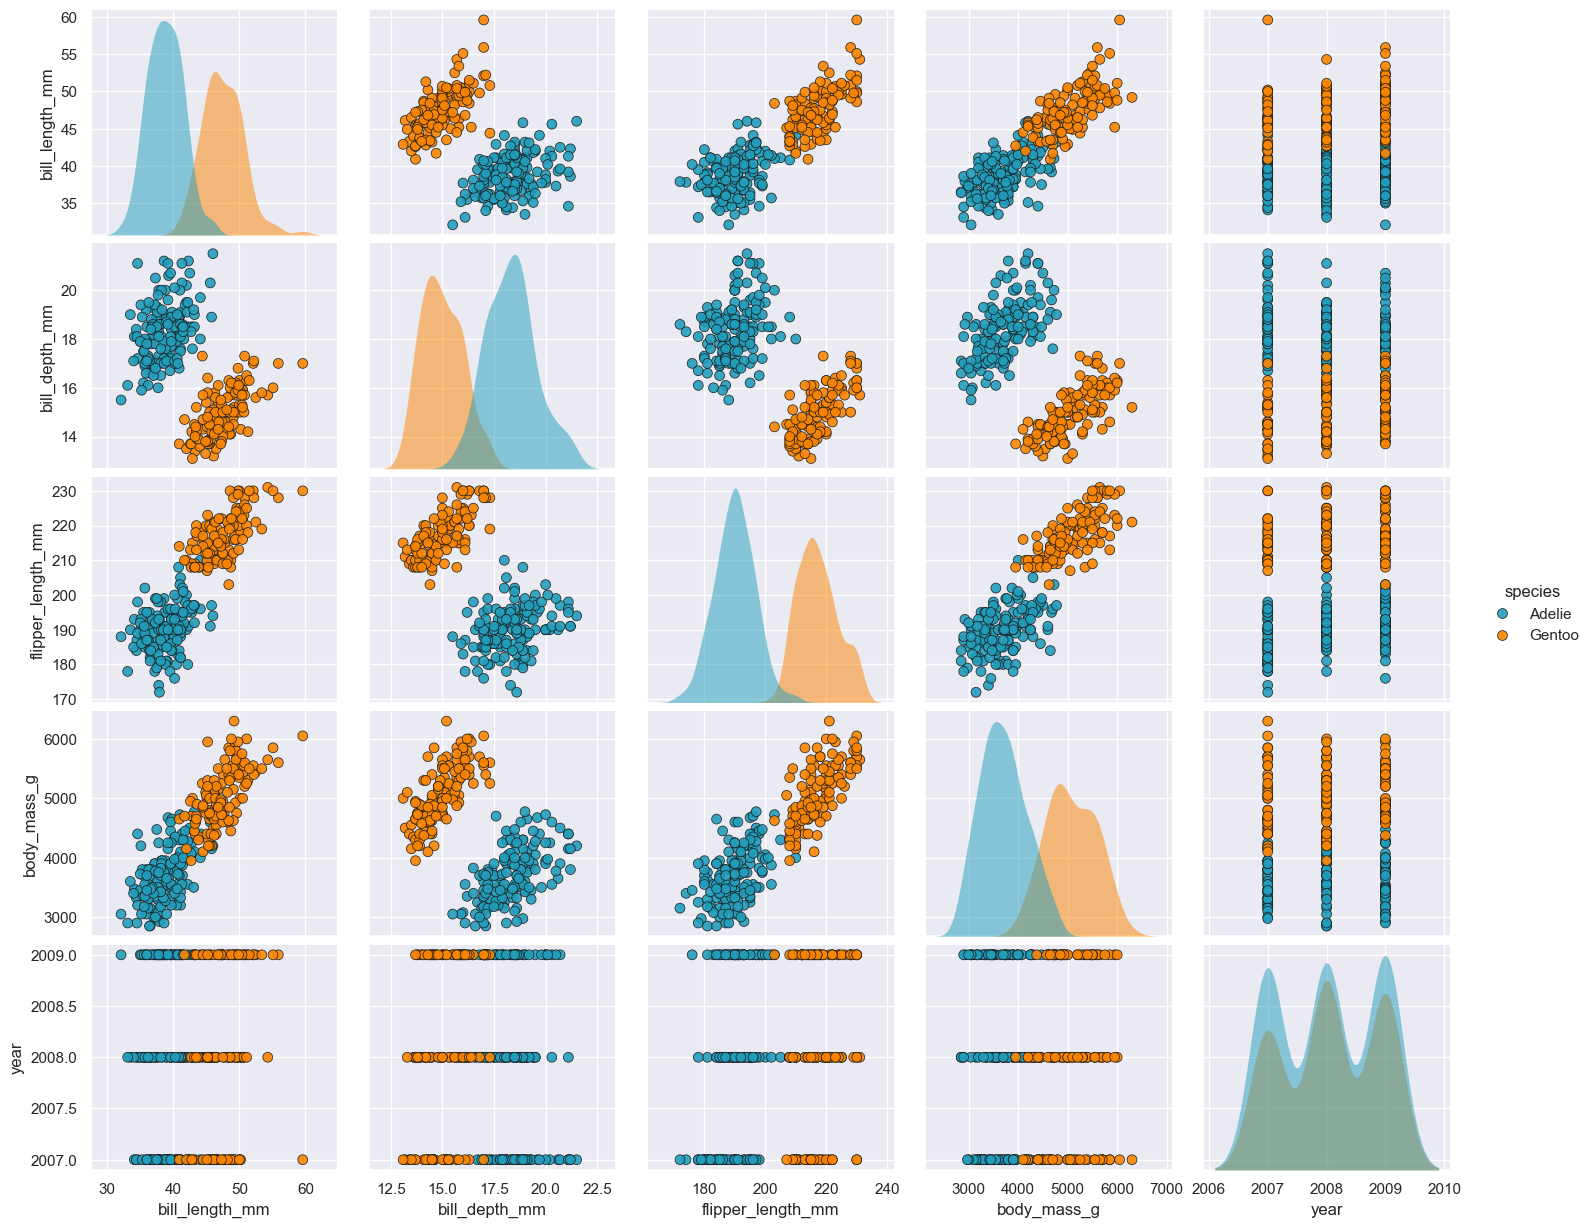

In [70]:
# make a seaborn pair plot of all the columns in the penguins data frame
sns.pairplot(penguins, hue="species", palette=pal, height=2.5, aspect=1.2, diag_kind="kde", diag_kws=dict(shade=True, alpha=0.5, linewidth=0), plot_kws=dict(s=50, alpha=0.9, edgecolor="k"))
sns.despine()
